# Population Simulator

In [1]:
import random

In [2]:
class Individual(object):
    """This class represents an individual."""

    def __init__(self, gamete1, gamete2):
        """
        @param genes1: sequence of alleles on first "chromosome".
        Each allele is a symbol; typically an integer or a random string.
        @param genes2: sequence of alleles on second "chronosome". """
        self.chromosomes = list(zip(gamete1, gamete2))

    @staticmethod
    def create_random(num_genes=1, num_alleles=2):
        gamete1, gamete2 = [[random.randint(0, num_alleles - 1) for _ in range(num_genes)] for g in range(2)]
        return Individual(gamete1, gamete2)

    def gamete(self):
        """Returns random gamete."""
        return [a[random.randint(0, 1)] for a in self.chromosomes]

    def __eq__(self, other):
        """Checks for genetic equality."""
        return self.chromosomes == other.chromosomes

    def __repr__(self):
        return str(self.chromosomes)


In [6]:
# chromosomes: [('A', 'a'), ('B', 'b')]
# Alleles: A, a, B, b
i = Individual(['A', 'B'], ['a', 'b'])
i.chromosomes


[('A', 'a'), ('B', 'b')]

In [167]:
class Population(object):
    """This class represents the snapshot of a population."""

    def __init__(self, individuals=None):
        self.individuals = individuals or []
        self.females, self.males = None, None
        self.full_fraction_list = []

    def __len__(self):
        return len(self.individuals)

    def __iter__(self):
        return iter(self.individuals)

    def add(self, individual):
        self.individuals.append(individual)

    def pick_individual(self):
        """Returns a random individual."""
        return random.choice(self.individuals)

    def random_mating(self):
        """Returns an individual produced via random mating."""
        g1 = self.pick_individual().gamete()
        g2 = self.pick_individual().gamete()
        return Individual(g1, g2)

    def random_hermaphrodite_mating(self):
        """Returns an individual generated via non-self mating,
        aka Banana Slug mating."""
        i1, i2 = random.sample(self.individuals, k=2)
        g1 = i1.gamete()
        g2 = i2.gamete()
        return Individual(g1, g2)

    def partition_genders_randomly(self, prob=0.5):
        """Partition the population in genders, randomly.
        Returns whether there is at least somebody of both genders."""
        self.males, self.females = [], []
        for x in self.individuals:
            if random.random() < prob:
                self.females.append(x)
            else:
                self.males.append(x)
        return len(self.females) > 0 and len(self.males) > 0

    def random_sexual_mating(self, prob=0.5):
        """This is a simple model, in which mating can happen only between
        individuals of opposite sex, and we are given the probability that an
        individual is of a given sex.
        We could do things in another way, but this is ok for now."""
        if self.females is None and self.males is None:
            feasible = self.partition_genders_randomly(prob=prob)
            if not feasible:
                return None
        f = random.choice(self.females)
        m = random.choice(self.males)
        return Individual(f.gamete(), m.gamete())

    def get_generation(self, method, *args, **kwargs):
        """Gets a new generation according to the given method."""
        new_pop = Population()
        for _ in range(len(self.individuals)):
            new_pop.add(method(self, *args, **kwargs))
        return new_pop


    def __repr__(self):
        """You can improve this..."""
        return "\n".join([str(i) for i in self.individuals])

    '''
    full_fraction_list is list of lists of [freq of 11, freq of 01, freq of 00] for each generation
    '''
    def update_fraction_list(self):
        allele_freq = {'[1, 1]': 0, '[0, 1]': 0, '[0, 0]': 0}
        total_freq = 0

        for i in self.individuals:
            for chromosome in i.chromosomes:
                sorted_chromosome = str(sorted(chromosome))
                if sorted_chromosome not in allele_freq:
                    allele_freq[sorted_chromosome] = 1
                else:
                    allele_freq[sorted_chromosome] += 1
                
                total_freq += 1
        
        prob_of_genes = {}
        for allele, freq in allele_freq.items():
            prob_of_genes[allele] = freq / total_freq

        return list(prob_of_genes.values())
            
            
    '''
    Caluclate actual F based on the fraction of hetero vs homo alleles in full_fraction_list
    '''
    def calculate_true_F(self):
        # for i in range(1, len(self.full_fraction_list)):
        if len(self.full_fraction_list) >= 2:
            g = self.full_fraction_list[-1]
            g_0 = self.full_fraction_list[-2] if len(self.full_fraction_list) >= 2 else 0
            pop_size = len(self.individuals)
            
            # prob of 1
            # (2(AA freq)N + (Aa freq)N) / 2N
            p_1 = (2 * g_0[0] * pop_size + g_0[1]*pop_size) / (2*pop_size)
            # prob of 0
            # (2N * (aa freq) + N * (Aa freq)) / 2N
            p_0 = (2 * g_0[2] * pop_size + g_0[1]*pop_size) / (2*pop_size)

            # if p_1*p_0 == 0:
            #     break

            F = ((2*p_1*p_0) - g[1]) / (2*p_1*p_0)
            
            return F
        return 0

    '''
    p = frequency of allele A
    q = frequency of allele a
    H_o = 2pq = normal heterozygot frequency
    H = observed heterozygot frequency
    F = (H_o - H) / H_o
    compute heterozygocity and homozygocity, compare to harvey weindberg
    '''
    def calculate_expected_F(self, full_fraction_list):
        # homozygote_prob = 0
        # for allele, prob in prob_of_genes:
        #     if allele[0] == allele[1]:
        #         homozygote_prob += prob

        # return homozygote_prob
        pass

    # f_t0 = 0
    def get_estimated_f(self, t):
        if (t == 0):
            return 0
        else:
            N = len(self.individuals)
            return 0.5 * N * (1-(0.5 * N)) * (self.get_f(t-1))

Here is a simple example

In [169]:
pop = Population()
f_ls = []
for j in range(1000):
    # print(f'Generation {j}')
    i = Individual.create_random(num_genes=2)
    pop.add(i)
    fraction = pop.update_fraction_list()
    # print(f'fraction: {fraction}')
    pop.full_fraction_list.append(fraction) 
    F = pop.calculate_true_F()
    # print(f'F: {F}')
    f_ls.append(F)

    # print(pop)

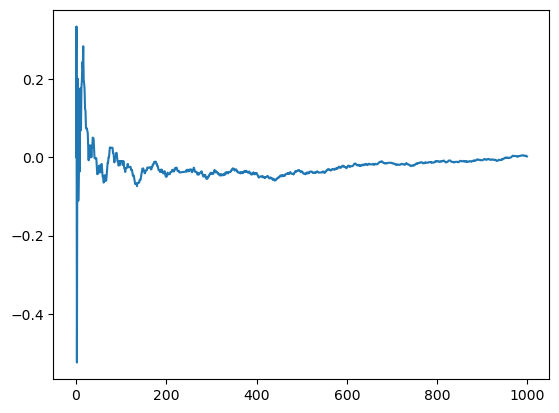

In [170]:
from matplotlib import pyplot as plt
plt.plot(f_ls)
plt.show()

In [161]:
# Let's simulate 100 generations.
pop = Population()
f_ls = []
for j in range(1000):
    i = Individual.create_random(num_genes=2)
    pop.add(i)
    F = pop.calculate_F(pop.gene_frequencies)[j]
    # print(F)
    f_ls.append(F)

plt.plot(f_ls)
plt.show()

AttributeError: 'Population' object has no attribute 'calculate_F'

Generation 0
pop.gene_frequencies[-1]: [0.6666666666666666, 0.16666666666666666, 0.16666666666666666]
F: 0
Generation 1
pop.gene_frequencies[-1]: [0.5, 0.25, 0.25]
F: 0.3333333333333333
Generation 2
pop.gene_frequencies[-1]: [0.4, 0.4, 0.2]
F: 0.1466666666666666
Generation 3
pop.gene_frequencies[-1]: [0.5, 0.3333333333333333, 0.16666666666666666]
F: 0.3055555555555558
Generation 4
pop.gene_frequencies[-1]: [0.5, 0.35714285714285715, 0.14285714285714285]
F: 0.19642857142857137
Generation 5
pop.gene_frequencies[-1]: [0.4375, 0.375, 0.1875]
F: 0.14035087719298237
Generation 6
pop.gene_frequencies[-1]: [0.4444444444444444, 0.3888888888888889, 0.16666666666666666]
F: 0.17037037037037037
Generation 7
pop.gene_frequencies[-1]: [0.45, 0.4, 0.15]
F: 0.13311036789297642
Generation 8
pop.gene_frequencies[-1]: [0.45454545454545453, 0.36363636363636365, 0.18181818181818182]
F: 0.2007992007992009
Generation 9
pop.gene_frequencies[-1]: [0.4166666666666667, 0.375, 0.20833333333333334]
F: 0.18973214285

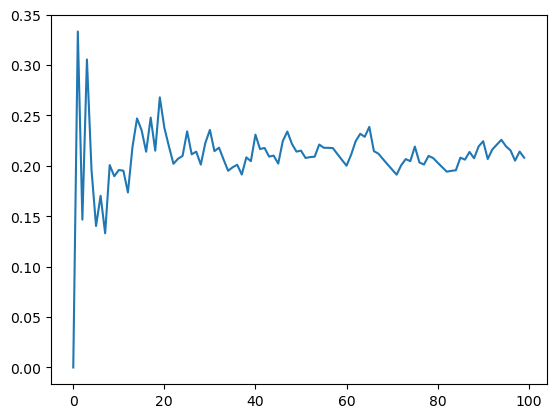

In [166]:
# Random Mating

ind_1 = Individual.create_random(num_genes=2)
ind_2 = Individual.create_random(num_genes=2)

pop = Population([ind_1,ind_2])
f_ls = []

for j in range(100):
    print(f'Generation {j}')
    i = pop.random_mating()
    pop.add(i)
    pop.update_gene_frequencies()
    print(f'pop.gene_frequencies[-1]: {pop.gene_frequencies[-1]}')
    F = pop.calculate_true_F()
    print(f'F: {F}')
    f_ls.append(F)

    # print(pop)

plt.plot(f_ls)
plt.show()

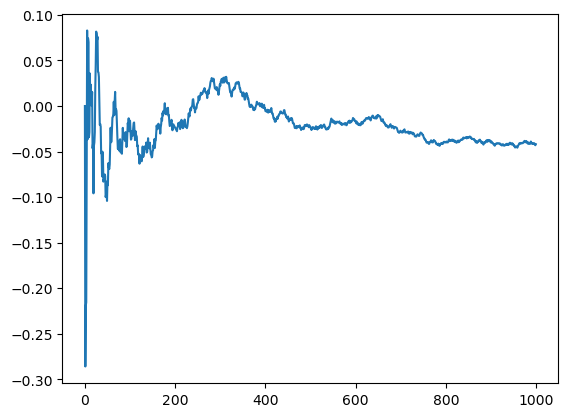

In [125]:
# Random sexual mating w/ 0.5

ind_1 = Individual.create_random(num_genes=2)
ind_2 = Individual.create_random(num_genes=2)
pop = Population([ind_1,ind_2])
f_ls = []
for j in range(1000):
    # print(f'Generation {j}')
    i = pop.random_sexual_mating(0.5)
    pop.add(i)
    pop.update_gene_frequencies()
    # print(f'fraction: {fraction}')
    F = pop.calculate_true_F()
    # print(f'F: {F}')
    f_ls.append(F)

    # print(pop)

plt.plot(f_ls)
plt.show()

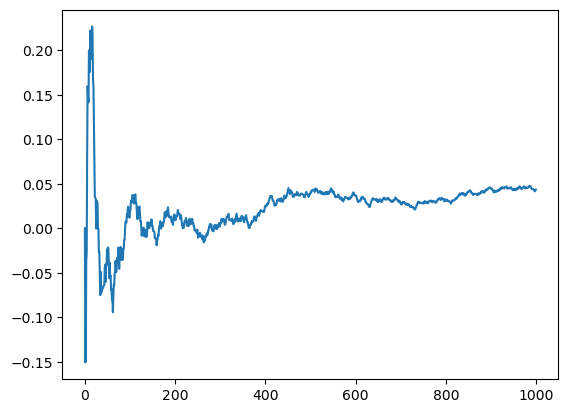

In [157]:
# random hermaphrodite mating w/ 0.95

ind_1 = Individual.create_random(num_genes=2)
ind_2 = Individual.create_random(num_genes=2)
ind_3 = Individual.create_random(num_genes=2)
ind_4 = Individual.create_random(num_genes=2)
ind_5 = Individual.create_random(num_genes=2)
pop = Population([ind_1,ind_2,ind_3,ind_4,ind_5])
f_ls = []
for j in range(1000):
    # print(f'Generation {j}')
    i = pop.random_hermaphrodite_mating()
    pop.add(i)
    pop.update_gene_frequencies()
    # print(f'fraction: {fraction}')
    F = pop.calculate_true_F()
    # print(f'F: {F}')
    f_ls.append(F)

    # print(pop)

plt.plot(f_ls)
plt.show()

In [ ]:
# Random sexual mating

ind_1 = Individual.create_random(num_genes=2)
ind_2 = Individual.create_random(num_genes=2)
ind_3 = Individual.create_random(num_genes=2)
ind_4 = Individual.create_random(num_genes=2)
ind_5 = Individual.create_random(num_genes=2)
pop = Population([ind_1,ind_2,ind_3,ind_4,ind_5])
f_ls = []
for j in range(1000):
    # print(f'Generation {j}')
    i = pop.random_sexual_mating(0.95)
    pop.add(i)
    pop.update_gene_frequencies()
    # print(f'fraction: {fraction}')
    F = pop.calculate_true_F()
    # print(f'F: {F}')
    f_ls.append(F)

    # print(pop)

plt.plot(f_ls)
plt.show()

In [128]:
# print(i)
# print(j)

# new_pop = Population([i,j])
# for j in range(100):
#     print(f'Generation {j}')
#     new_pop.add(new_pop.random_mating())
    
#     print(pop)
#     print(pop.get_true_f(1))
#     new_pop.update_gene_frequencies()[j]
#     print(updated_fraction_list)
#     new_pop.full_fraction_list.append(new_pop.update_gene_frequencies()[j]) 
#     F = pop.calculate_F(new_pop.full_fraction_list)
#     print(F)
#     f_ls.append(F)
# plt.plot(f_ls)
# plt.show()